# SVM

In [1]:
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from utilities import plot_classification


/Users/henry/Git/ml-algorithms/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Objective of SVM

The goal of SVM is to find the hyperplane that maximizes the margin between the two classes. This is known as the maximum margin classifier. The intuition is that a larger margin leads to better generalization on unseen data.

The classifier (or decision function) is defined as:

$$
f(x) = \text{sign}(w^Tx + b)
$$

- When f(x) > 0, then point is classified as +1.
- When f(x) < 0, then point is classified as -1.
- The value of f(x) represents the signed distances of the data x from the hyperplane

In [2]:
def svm_classify(X, w, b):
    """
    Classifies the given input X using the SVM parameters w and b.

    Parameters:
    X (num_samples, num_features)
    w (num_features)
    b (scalar)

    Returns:
    int
        The class label, either 1 or -1, based on the decision boundary.
    """
    decision_values = np.dot(X, w) + b
    return np.where(decision_values > 0, 1, -1)

## Geometric Margin

$$
\text{Margin}_i = \frac{y_i(w^Tx_i + b)}{\|w\|}
$$

Remember that the label $y_i \in \{0, 1\}$, so multiplying the classifier $w^Tx_i + b$ by $y_i$ gives us a signed result. If the point is correctly classified, the result is positive. If the point is misclassified, the result is negative.

## Hinge Loss


We will also denote that $max(0, 1 - y_i(w^Tx_i + b))$ as the **hinge loss**. 
- If the sample was correctly classified, then $1 - y_i(w^Tx_i + b)$ is negative, and loss functions typically doesn't go into the negatives (better than perfect doesn't exist). So we use a floor to make sure the hinge loss in the correct classification case is 0. 
- If the sample was misclassified, then $1 - y_i(w^Tx_i + b)$ is positive, and the hinge loss is positive.

## Objective Function

To maximize the margin, we need to minimize the deonominator $\|w\|$, subject to the constraint that all the points are correctly classified.

Formally:

$$
\begin{align*}
\min_{w, b} & \frac{1}{2}\|w\|^2 \quad \\
\text{subject to} & \quad y_i(w^Tx_i + b) \geq 1 \quad \forall i \tag*{a.k.a. correctly classified}
\end{align*}
$$

The >= 1 is also known as the **hard-margin SVM**. The $\frac{1}{2}$ is just for convenience, it doesn't change the solution but makes gradient computation easier to cancel out the power of 2 with $\frac{1}{2}$.

## Slack Variables

Since we don't live in a perfect world, so we know that a perfect separation doesn't exist. We need some kind of "softer" condition to converge towards. We introduce slack variables $\xi_i$ to allow for misclassification.

The constraint is formally defined as:

$$
y_i(w^Tx_i + b) \geq 1 - \xi_i  \tag*{(no need to be perfectly >= 1)}
$$

where 
$$
\xi_i \geq 0
$$

The >= 1 - $\xi_i$ is also known as the **soft-margin SVM**.

## Tying back to the objective function

We want to minimize the amount of slack/margin violation $\xi$, which is captured by $\sum_{i=1}^n \xi_i$. Therefore, we simply add this term to the objective function with a hyperparameter $C$ to control the trade-off between the maximizing the margin and minimizing the slack.

Formally:

$$
\begin{align*}
\min_{w, b, \xi} & \frac{1}{2}\|w\|^2 + C\sum_{i=1}^n \xi_i \quad \\
\text{subject to} & \quad y_i(w^Tx_i + b) \geq 1 - \xi_i \quad \forall i \\
& \quad \xi_i \geq 0 \quad \forall i
\end{align*}
$$

- We can see with a higher $C$, we put more emphasis on minimizing the slack, which leads to a smaller margin, and thus penalizing the misclassifications more heavily.
- On the other hand, with a lower $C$, the "price" we pay for misclassification goes down, so we put more emphasis on maximizing the margin, which leads to a larger margin but more slack.

The final objective function becomes:

$$
\min_{w, b, \xi} \frac{1}{2}\|w\|^2 + C\sum_{i=1}^n max(0, (1 - y_i(w^Tx_i + b)))
$$

## Gradient fo the objective function w.r.t weights

$$
\begin{align}
\frac{\partial}{\partial w} \frac{1}{2}\|w\|^2 &= w \\
\frac{\partial}{\partial w} C\sum_{i=1}^n \xi_i &= 0 \\
\frac{\partial}{\partial w} \text{Loss} &= max(0, (1 - y_i(w^Tx_i + b))) \\
&= 1 - y_i(w^Tx_i + b) \tag{if $y_i(w^Tx_i + b) < 1$} \\
&= -y_ix_i
\end{align}
$$

- In (1), setting the gradient to 0, effectively maximizing the margin.
- In (2), the gradient is 0, so it doesn't affect the weights.
- In (3) and (4), we can see that the gradient is only non-zero when the point is misclassified, which is exactly what we want.

$$
\frac{\partial}{\partial b} = 1 - y_i(w^Tx_i + b) = -y_i
$$

The bias graident is simpliy the label $y_i$ when the point is misclassified.

In [3]:
def train_svm(X, y, learning_rate=0.01, C=0.01, num_epochs=100):
    # Initialize weights and bias
    w = np.zeros(X.shape[1])
    b = 0
    y_pred = svm_classify(X, w, b)
    plot_classification(y, y_pred, "before running SVM")
    
    for epoch in range(num_epochs):
        decision = svm_classify(X, w, b)
        misclassified_mask = decision < 1
        
        assert decision.shape == (X.shape[0],)
        assert misclassified_mask.shape == (X.shape[0],)
        assert y.shape == (X.shape[0],)
        
        # Only misclassified examples affects the gradients based on max(0, (1 - y(w^Tx + b)))
        loss = np.maximum(0, 1 - y * decision)
        gradient_w = np.mean(-C * (misclassified_mask[:, np.newaxis] * y[:, np.newaxis] * X))
        w -= learning_rate * w / X.shape[0] + gradient_w
        gradient_b = np.mean(C * y * (decision < 1))
        b -= learning_rate * gradient_b
        
        if epoch % (num_epochs // 10) == 0:
            print(f"Epoch {epoch} Loss: {np.mean(loss)}")
    
    return w, b

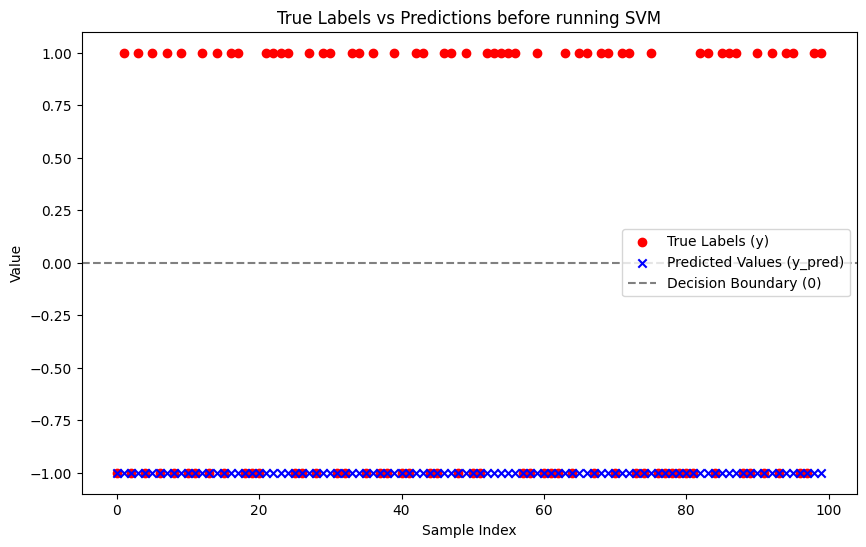

Epoch 0 Loss: 1.0
Epoch 2 Loss: 0.88
Epoch 4 Loss: 0.88
Epoch 6 Loss: 0.88
Epoch 8 Loss: 0.88
Epoch 10 Loss: 0.88
Epoch 12 Loss: 0.88
Epoch 14 Loss: 0.88
Epoch 16 Loss: 0.88
Epoch 18 Loss: 0.88


In [4]:
X, y = make_classification(n_samples=100, n_features=30)
y = np.where(y <= 0, -1, 1) # convert labels to -1 and 1
w, b = train_svm(X, y, learning_rate=0.001, C=0.01, num_epochs=20)

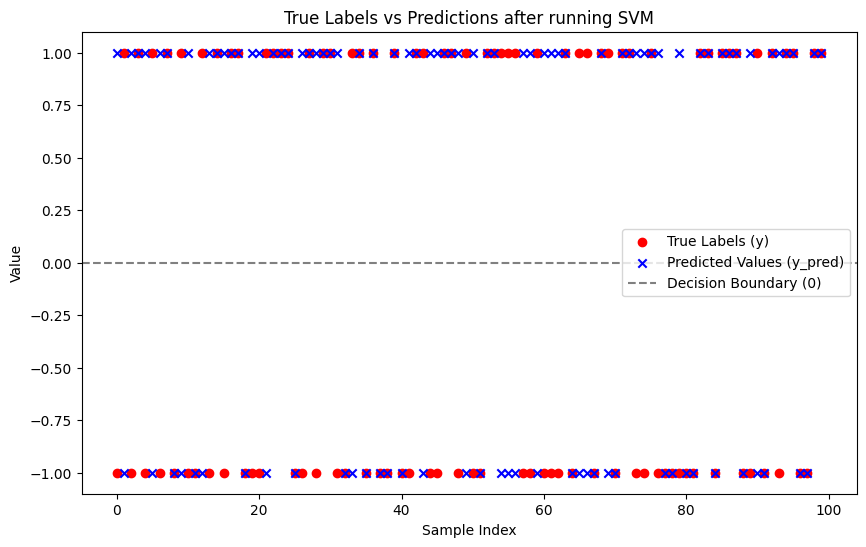

In [5]:
y_pred = svm_classify(X, w, b)
plot_classification(y, y_pred, "after running SVM")